In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from cv2 import aruco
import msgpack as mp
import msgpack_numpy as mpn
from tqdm import tqdm
import sys

sys.path.insert(1, os.path.dirname(os.getcwd()))
from pd_support import *
from scipy.spatial.transform import Rotation as R
import polars as pl
import os
from scipy.interpolate import interp1d
from joblib import Parallel, delayed

## Define calibration path

In [3]:
_pth = os.path.dirname(os.path.dirname(os.getcwd()))
_parent_folder = "data"
_calib_folder_name = "calib_mono_chessboard_corners"

_webcam_calib_folder = os.path.join(
    _pth, _parent_folder, "calibration", _calib_folder_name
)
_webcam_calib_video = os.path.join(_webcam_calib_folder, "test.msgpack")

In [4]:
chessb_corners = mp.Unpacker(open(_webcam_calib_video, 'rb'), object_hook=mpn.decode)
chessb_corners = list(chessb_corners)
chessb_corners = np.array(chessb_corners)

In [5]:
useDeng = False
cameraNumber = 4
useFisheye = True

patternSize = (6, 4)
squareSize = 30
imgSize = (1200, 800)

criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)


def construct3DPoints(patternSize, squareSize):
    X = np.zeros((patternSize[0] * patternSize[1], 3), np.float32)
    X[:, :2] = np.mgrid[0 : patternSize[0], 0 : patternSize[1]].T.reshape(-1, 2)
    X = X * squareSize
    return X


boardPoints = construct3DPoints(patternSize, squareSize)


In [5]:
my_dict = {'ReError': [], 'mat': [], 'dist': [], 'rvec': [], 'tvec': []}

def calibrate_single_iteration(_):
    rnd = np.random.choice(len(chessb_corners), 20, replace=False)
    chessb_c = chessb_corners[rnd]
    worldPoints = []
    imagePoints = []

    for _f in chessb_c:
        imagePoints.append(_f)
        worldPoints.append(boardPoints)

    if useFisheye:
        flagsCalib = (
            cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC
            + cv2.fisheye.CALIB_FIX_SKEW
            + cv2.fisheye.CALIB_CHECK_COND
        )
        calibrateCriteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-12)
        ret, cameraMatrix, k, R, t = cv2.fisheye.calibrate(
            np.expand_dims(np.asarray(worldPoints), -2),
            imagePoints,
            imgSize,
            None,
            None,
            flags=flagsCalib,
            criteria=calibrateCriteria,
        )
    else:
        flagsCalib = cv2.CALIB_RATIONAL_MODEL
        ret, cameraMatrix, k, R, t = cv2.calibrateCamera(
            worldPoints, imagePoints, imgSize, None, None, flags=flagsCalib
        )

    return {'ReError': ret, 'mat': cameraMatrix, 'dist': k, 'rvec': R, 'tvec': t}

# Parallel execution with joblib
results = Parallel(n_jobs=20)(
    delayed(calibrate_single_iteration)(_) for _ in tqdm(range(5000), colour='green')
)

# Collect results
for result in results:
    my_dict['ReError'].append(result['ReError'])
    my_dict['mat'].append(result['mat'])
    my_dict['dist'].append(result['dist'])
    my_dict['rvec'].append(result['rvec'])
    my_dict['tvec'].append(result['tvec'])

100%|██████████| 5000/5000 [01:57<00:00, 42.46it/s]


## Full calibration

In [6]:
chessb_c = chessb_corners
worldPoints = []
imagePoints = []

for _f in chessb_c:
    imagePoints.append(_f)
    worldPoints.append(boardPoints)

if useFisheye:
    flagsCalib = (
        cv2.fisheye.CALIB_RECOMPUTE_EXTRINSIC
        + cv2.fisheye.CALIB_FIX_SKEW
        + cv2.fisheye.CALIB_CHECK_COND
    )
    calibrateCriteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-12)
    ret, cameraMatrix, k, R, t = cv2.fisheye.calibrate(
        np.expand_dims(np.asarray(worldPoints), -2),
        imagePoints,
        imgSize,
        None,
        None,
        flags=flagsCalib,
        criteria=calibrateCriteria,
    )
else:
    flagsCalib = cv2.CALIB_RATIONAL_MODEL
    ret, cameraMatrix, k, R, t = cv2.calibrateCamera(
        worldPoints, imagePoints, imgSize, None, None, flags=flagsCalib
    )

_fish_matrix = cameraMatrix
_fist_dist = k

In [22]:
_fish_matrix = cameraMatrix
_fist_dist = k

## path definition

In [7]:
_recording_dir = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), "data")
_data_dir = "mono_raw_t0"
_data_path = os.path.join(
    _recording_dir, "recordings", _data_dir, "webcam_color.msgpack"
)

ar_parameters = aruco.DetectorParameters()
ar_dict = aruco.getPredefinedDictionary(aruco.DICT_APRILTAG_36H11)
ar_detector = aruco.ArucoDetector(ar_dict, ar_parameters)
markerLength = 0.06
markerSeperation = 0.01

default_ids = [4, 8, 12, 14, 20]

board = aruco.GridBoard(
    size=[1, 1],
    markerLength=markerLength,
    markerSeparation=markerSeperation,
    dictionary=ar_dict,
)

In [8]:
def estimate_pose_single_markers(
    corners, marker_size, camera_matrix, distortion_coefficients
):
    marker_points = np.array(
        [
            [-marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, marker_size / 2, 0],
            [marker_size / 2, -marker_size / 2, 0],
            [-marker_size / 2, -marker_size / 2, 0],
        ],
        dtype=np.float32,
    )
    rvecs = []
    tvecs = []
    for corner in corners:
        _, r, t = cv2.solvePnP(
            marker_points,
            corner,
            camera_matrix,
            distortion_coefficients,
            True,
            flags=cv2.SOLVEPNP_IPPE_SQUARE,
        )
        if r is not None and t is not None:
            r = np.array(r).reshape(1, 3).tolist()
            t = np.array(t).reshape(1, 3).tolist()
            rvecs.append(r)
            tvecs.append(t)
    return np.array(rvecs, dtype=np.float32), np.array(tvecs, dtype=np.float32)

In [9]:
ARUCO_PARAMETERS = aruco.DetectorParameters()
ARUCO_DICT = aruco.getPredefinedDictionary(aruco.DICT_APRILTAG_36H11)
detector = aruco.ArucoDetector(ARUCO_DICT, ARUCO_PARAMETERS)
markerLength = 0.05
markerSeperation = 0.01

board = aruco.GridBoard(
    size=[1, 1],
    markerLength=markerLength,
    markerSeparation=markerSeperation,
    dictionary=ARUCO_DICT,
)

In [10]:
calibration_flags = cv2.CALIB_CB_CLUSTERING
term_criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 1e-6)

In [11]:
corners, ids = [], []
with open(_data_path, "rb") as _f:
    unpacker = mp.Unpacker(_f, object_hook=mpn.decode)
    for _frame in tqdm(unpacker):
        _c, _i, rejectedpoints = detector.detectMarkers(_frame)
        _c, _i, rejectedpoints, _ = detector.refineDetectedMarkers(
            image=_frame,
            board=board,
            detectedCorners=_c,
            detectedIds=_i,
            rejectedCorners=rejectedpoints,
        )
        corners.append(_c)
        ids.append(_i)

timestamp = []
sync = []

with open(
    os.path.join(os.path.dirname(_data_path), "webcam_timestamp.msgpack"), "rb"
) as _f:
    unpacker = mp.Unpacker(_f, object_hook=mpn.decode)
    for _p in unpacker:
        sync.append(_p[0])
        timestamp.append(_p[1])
sync = np.array(sync).astype(bool)

5159it [00:26, 196.43it/s]


In [12]:
ar_df = {"time": timestamp, "sync": sync}
ar_df = pl.from_dict(ar_df)
if type(ar_df["time"][0]) is not datetime:
    ar_df = ar_df.with_columns(pl.col("time").str.to_datetime())

In [13]:
mocap_df, st_time = read_rigid_body_csv(
    os.path.join(os.path.dirname(_data_path), f"{_data_dir}.csv")
)
mocap_df = add_datetime_col(mocap_df, st_time, "seconds")
mocap_df = pl.from_pandas(mocap_df)

e:\CMC\pyprojects\programs_rpi\rpi_python\notebooks\pd_support.py:326: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  _rb_df = _rb_df.apply(pd.to_numeric, errors="ignore")


In [14]:
tr = get_rb_marker_name(1)
tl = get_rb_marker_name(4)
br = get_rb_marker_name(2)
bl = get_rb_marker_name(5)

tr = get_rb_marker_name(1)
tl = get_rb_marker_name(4)
br = get_rb_marker_name(5)
bl = get_rb_marker_name(6)


# tr = get_rb_marker_name(4)
# tl = get_rb_marker_name(2)
# br = get_rb_marker_name(3)
# bl = get_rb_marker_name(1)

In [15]:
pulse_sweep = False
for idx, val in enumerate(ar_df["sync"]):
    if val == True and not pulse_sweep:
        start_pulse = idx
        pulse_sweep = True
    if val == False and pulse_sweep:
        end_pulse = idx
        break
ar_df = ar_df[start_pulse:end_pulse]
corners = corners[start_pulse:end_pulse]
ids = ids[start_pulse:end_pulse]

_time_diff = ar_df["time"][0] - mocap_df["time"][0]

ar_df = ar_df.with_columns([(pl.col("time") - _time_diff).alias("time")])

In [18]:
mocap_mean = {"x": [], "y": [], "z": []}
mocap_mean["x"] = mocap_df[[tr["x"], tl["x"], br["x"], bl["x"]]].to_numpy().mean(axis=1)
mocap_mean["y"] = mocap_df[[tr["y"], tl["y"], br["y"], bl["y"]]].to_numpy().mean(axis=1)
mocap_mean["z"] = mocap_df[[tr["z"], tl["z"], br["z"], bl["z"]]].to_numpy().mean(axis=1)

mocap_qt_0 = mocap_df[["rb_ang_x", "rb_ang_y", "rb_ang_z", "rb_ang_w"]][0].to_numpy()

mocap_rotation = R.from_quat(mocap_qt_0).as_matrix()

mocap_mean = pl.from_dict(mocap_mean)

mt_dict = {"x": [], "y": [], "z": []}
rmat_m = mocap_rotation[0]

for i in range(len(mocap_df["time"])):
    tvec_ar = rmat_m.T @ (
        mocap_mean[["x", "y", "z"]][i].to_numpy().reshape(3, 1)
        - mocap_mean[["x", "y", "z"]][0].to_numpy().reshape(3, 1)
    )
    tvec_ar = tvec_ar.T[0]
    mt_dict["x"].append(tvec_ar[0])
    mt_dict["y"].append(tvec_ar[1])
    mt_dict["z"].append(tvec_ar[2])

mt_dict["time"] = mocap_df["time"]

In [19]:
mc_angle_arr = mocap_df[["rb_ang_x", "rb_ang_y", "rb_ang_z", "rb_ang_w"]].to_numpy()
mocap_angle = []
mc_ang_x = []
mc_ang_y = []
mc_ang_z = []
for _a in mc_angle_arr:
    try:
        _ax, _ay, _az = R.from_matrix(
            mocap_rotation[0].T @ R.from_quat(_a).as_matrix()
        ).as_euler("xyz", degrees=True)
        mc_ang_x.append(_ax)
        mc_ang_y.append(_ay)
        mc_ang_z.append(_az)
    except:
        _ax, _ay, _az = R.from_matrix(mocap_rotation[0].T @ np.eye(3)).as_euler(
            "xyz", degrees=True
        )
        mc_ang_x.append(_ax)
        mc_ang_y.append(_ay)
        mc_ang_z.append(_az)

## Interoplating

In [20]:
mocap = pl.from_dict(mt_dict)

x1 = interp1d(mocap["time"].dt.epoch(), mocap["x"], fill_value="extrapolate")
y1 = interp1d(mocap["time"].dt.epoch(), mocap["y"], fill_value="extrapolate")
z1 = interp1d(mocap["time"].dt.epoch(), mocap["z"], fill_value="extrapolate")

ax = interp1d(mocap["time"].dt.epoch(), mc_ang_x, fill_value="extrapolate")
ay = interp1d(mocap["time"].dt.epoch(), mc_ang_y, fill_value="extrapolate")
az = interp1d(mocap["time"].dt.epoch(), mc_ang_z, fill_value="extrapolate")

mocap_ip = {"time": ar_df["time"]}
mocap_ip["x"] = x1(ar_df["time"].dt.epoch())
mocap_ip["y"] = y1(ar_df["time"].dt.epoch())
mocap_ip["z"] = z1(ar_df["time"].dt.epoch())
mocap_ip["rx"] = ax(ar_df["time"].dt.epoch())
mocap_ip["ry"] = ay(ar_df["time"].dt.epoch())
mocap_ip["rz"] = az(ar_df["time"].dt.epoch())

mocap_ip = pl.from_dict(mocap_ip)

In [27]:
error_dict = {
'err_x':[],
'err_y':[], 
'err_z':[],
'mean_err':[],
'idx':[]

}

for _i in tqdm(range(len(my_dict['mat']))):
    _fish_mat = my_dict['mat'][_i]
    _fish_dist = my_dict['dist'][_i]
    _new_cam = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(_fish_mat, _fish_dist, (1200, 800), np.eye(3), balance=1)

    undist_corners = []
    for _corner in corners:
        _uc = cv2.fisheye.undistortPoints(np.array(_corner).reshape(-1, 1, 2), _fish_mat, _fish_dist, None, _new_cam)
        undist_corners.append(_uc)

    camera_matrix = _new_cam
    dist_coeffs = _fish_dist

    rvecs = []
    tvecs = []
    rotation_vectors = None
    translation_vectors = None
    for _c, _i in zip(undist_corners, ids):
        if (_i is not None and len(_i) > 0) and all(
            item in default_ids for item in np.array(_i)
        ):
            _c = np.array([_c.reshape(-1,2)]).astype(np.float32)
            rotation_vectors, translation_vectors = estimate_pose_single_markers(
                corners=_c,
                marker_size=0.05,
                camera_matrix=camera_matrix,
                distortion_coefficients=dist_coeffs,
            )

            try:
                rvecs.append(rotation_vectors[0][0])
                tvecs.append(translation_vectors[0][0])
            except:
                rvecs.append(np.array([np.nan, np.nan, np.nan]))
                tvecs.append(np.array([np.nan, np.nan, np.nan]))
        else:
            rvecs.append(np.array([np.nan, np.nan, np.nan]))
            tvecs.append(np.array([np.nan, np.nan, np.nan]))
    tvecs = np.array(tvecs)
    rvecs = np.array(rvecs)

    t_dict = {"x": [], "y": [], "z": []}
    ang_dict = {"rx": [], "ry": [], "rz": []}
    rmat = cv2.Rodrigues(rvecs[1])[0]

    for i in range(len(tvecs)):
        tvec = rmat.T @ (tvecs[i].reshape(3, 1) - tvecs[1].reshape(3, 1))
        tvec = tvec.T[0]
        t_dict["x"].append(tvec[0])
        t_dict["y"].append(tvec[1])
        t_dict["z"].append(tvec[2])

        _del_r = R.from_matrix(
            rmat.T @ R.from_rotvec(rvecs[0]).as_matrix()
        ).as_euler("xyz", degrees=True)
        ang_dict["rx"].append(_del_r[0])
        ang_dict["ry"].append(_del_r[1])
        ang_dict["rz"].append(_del_r[2])
    # print(t_dict)
    _ex = np.nanmean(abs(np.array(t_dict["x"]) - (mocap_ip["x"])).to_numpy())
    _ey = np.nanmean(abs(np.array(t_dict["y"]) - (mocap_ip["y"])).to_numpy())
    _ez = np.nanmean(abs(np.array(t_dict["z"]) - (mocap_ip["z"])).to_numpy())

    _mean_err = np.nanmean([_ex, _ey, _ez])
    _max_x = np.nanmax(abs(np.array(t_dict["x"]) - (mocap_ip["x"])).to_numpy())
    _max_y = np.nanmax(abs(np.array(t_dict["y"]) - (mocap_ip["y"])).to_numpy())
    _max_z = np.nanmax(abs(np.array(t_dict["z"]) - (mocap_ip["z"])).to_numpy())

    _eax = np.nanmean(abs(np.array(ang_dict["rx"]) - (mocap_ip["rx"])).to_numpy())
    _eay = np.nanmean(abs(np.array(ang_dict["ry"]) - (mocap_ip["ry"])).to_numpy())
    _eaz = np.nanmean(abs(np.array(ang_dict["rz"]) - (mocap_ip["rz"])).to_numpy())

    _mean_error_ang = np.nanmean([_eax, _eay, _eaz])

    error_dict['err_x'].append(_max_x)
    error_dict['err_y'].append(_max_y)
    error_dict['err_z'].append(_max_z)
    error_dict['mean_err'].append(_mean_err)
    error_dict['idx'].append(_i)

100%|██████████| 5000/5000 [16:54<00:00,  4.93it/s]


In [28]:
backup_dict = error_dict.copy()

## estimation

In [30]:
with open(os.path.join(_webcam_calib_video), "rb") as _f:
    data = list(mp.Unpacker(_f, object_hook=mpn.decode))
img_size = data[0]
video_data = data[1:]

In [31]:
import concurrent.futures


def process_item(dummy):

    _i = dummy
    _fish_mat = my_dict['mat'][_i]
    _fish_dist = my_dict['dist'][_i]
    _new_cam = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(_fish_mat, _fish_dist, (1200, 800), np.eye(3), balance=1)

    undist_corners = []
    for _corner in corners:
        _uc = cv2.fisheye.undistortPoints(np.array(_corner).reshape(-1, 1, 2), _fish_mat, _fish_dist, None, _new_cam)
        undist_corners.append(_uc)

    camera_matrix = _new_cam
    dist_coeffs = _fish_dist

    rvecs = []
    tvecs = []
    rotation_vectors = None
    translation_vectors = None
    for _c, _i in zip(undist_corners, ids):
        if (_i is not None and len(_i) > 0) and all(
            item in default_ids for item in np.array(_i)
        ):
            _c = np.array([_c.reshape(-1,2)]).astype(np.float32)
            rotation_vectors, translation_vectors = estimate_pose_single_markers(
                corners=_c,
                marker_size=0.05,
                camera_matrix=camera_matrix,
                distortion_coefficients=dist_coeffs,
            )

            try:
                rvecs.append(rotation_vectors[0][0])
                tvecs.append(translation_vectors[0][0])
            except:
                rvecs.append(np.array([np.nan, np.nan, np.nan]))
                tvecs.append(np.array([np.nan, np.nan, np.nan]))
        else:
            rvecs.append(np.array([np.nan, np.nan, np.nan]))
            tvecs.append(np.array([np.nan, np.nan, np.nan]))
    tvecs = np.array(tvecs)
    rvecs = np.array(rvecs)

    t_dict = {"x": [], "y": [], "z": []}
    ang_dict = {"rx": [], "ry": [], "rz": []}
    rmat = cv2.Rodrigues(rvecs[1])[0]

    for i in range(len(tvecs)):
        tvec = rmat.T @ (tvecs[i].reshape(3, 1) - tvecs[1].reshape(3, 1))
        tvec = tvec.T[0]
        t_dict["x"].append(tvec[0])
        t_dict["y"].append(tvec[1])
        t_dict["z"].append(tvec[2])

        _del_r = R.from_matrix(
            rmat.T @ R.from_rotvec(rvecs[0]).as_matrix()
        ).as_euler("xyz", degrees=True)
        ang_dict["rx"].append(_del_r[0])
        ang_dict["ry"].append(_del_r[1])
        ang_dict["rz"].append(_del_r[2])


        t_dict = {"x": [], "y": [], "z": []}
        ang_dict = {"rx": [], "ry": [], "rz": []}
        rmat = cv2.Rodrigues(rvecs[1])[0]

    _ex = np.nanmean(abs(np.array(t_dict["x"]) - (mocap_ip["x"])).to_numpy())
    _ey = np.nanmean(abs(np.array(t_dict["y"]) - (mocap_ip["y"])).to_numpy())
    _ez = np.nanmean(abs(np.array(t_dict["z"]) - (mocap_ip["z"])).to_numpy())

    _mean_err = np.nanmean([_ex, _ey, _ez])
    _max_x = np.nanmax(abs(np.array(t_dict["x"]) - (mocap_ip["x"])).to_numpy())
    _max_y = np.nanmax(abs(np.array(t_dict["y"]) - (mocap_ip["y"])).to_numpy())
    _max_z = np.nanmax(abs(np.array(t_dict["z"]) - (mocap_ip["z"])).to_numpy())

    _eax = np.nanmean(abs(np.array(ang_dict["rx"]) - (mocap_ip["rx"])).to_numpy())
    _eay = np.nanmean(abs(np.array(ang_dict["ry"]) - (mocap_ip["ry"])).to_numpy())
    _eaz = np.nanmean(abs(np.array(ang_dict["rz"]) - (mocap_ip["rz"])).to_numpy())

    _mean_error_ang = np.nanmean([_eax, _eay, _eaz])

    return (
        None,
        _ex,
        _ey,
        _ez,
        _fish_mat,
        dist_coeffs,
        _mean_err,
        _max_x,
        _max_y,
        _max_z,
        _eax,
        _eay,
        _eaz,
        _mean_error_ang,
    )


# List of items to process
items = np.arange(5000)

results = []

# Use ThreadPoolExecutor to process items in parallel
with concurrent.futures.ThreadPoolExecutor() as executor:
    # Map the function to the items list and execute in parallel
    future_to_item = {executor.submit(process_item, item): item for item in items}

    for future in tqdm(concurrent.futures.as_completed(future_to_item)):
        item = future_to_item[future]
        try:
            result = future.result()
            if result is not None:
                results.append(result)
        except Exception as exc:
            print(f"{item} generated an exception: {exc}")

3it [00:12,  3.34s/it]

13 generated an exception: operands could not be broadcast together with shapes (0,) (4198,) (4198,) 
14 generated an exception: operands could not be broadcast together with shapes (0,) (4198,) (4198,) 
21 generated an exception: operands could not be broadcast together with shapes (0,) (4198,) (4198,) 


5it [00:12,  1.66s/it]

23 generated an exception: operands could not be broadcast together with shapes (0,) (4198,) (4198,) 
4 generated an exception: operands could not be broadcast together with shapes (0,) (4198,) (4198,) 


9it [00:13,  1.56it/s]

12 generated an exception: operands could not be broadcast together with shapes (0,) (4198,) (4198,) 
2 generated an exception: operands could not be broadcast together with shapes (0,) (4198,) (4198,) 
22 generated an exception: operands could not be broadcast together with shapes (0,) (4198,) (4198,) 
17 generated an exception: operands could not be broadcast together with shapes (0,) (4198,) (4198,) 
5 generated an exception: operands could not be broadcast together with shapes (0,) (4198,) (4198,) 


19it [00:13,  6.17it/s]

11 generated an exception: operands could not be broadcast together with shapes (0,) (4198,) (4198,) 
20 generated an exception: operands could not be broadcast together with shapes (0,) (4198,) (4198,) 
16 generated an exception: operands could not be broadcast together with shapes (0,) (4198,) (4198,) 
1 generated an exception: operands could not be broadcast together with shapes (0,) (4198,) (4198,) 
18 generated an exception: operands could not be broadcast together with shapes (0,) (4198,) (4198,) 
7 generated an exception: operands could not be broadcast together with shapes (0,) (4198,) (4198,) 
26 generated an exception: operands could not be broadcast together with shapes (0,) (4198,) (4198,) 
15 generated an exception: operands could not be broadcast together with shapes (0,) (4198,) (4198,) 
9 generated an exception: operands could not be broadcast together with shapes (0,) (4198,) (4198,) 
3 generated an exception: operands could not be broadcast together with shapes (0,) (

24it [00:13,  9.13it/s]

19 generated an exception: operands could not be broadcast together with shapes (0,) (4198,) (4198,) 
0 generated an exception: operands could not be broadcast together with shapes (0,) (4198,) (4198,) 
6 generated an exception: operands could not be broadcast together with shapes (0,) (4198,) (4198,) 
24 generated an exception: operands could not be broadcast together with shapes (0,) (4198,) (4198,) 
25 generated an exception: operands could not be broadcast together with shapes (0,) (4198,) (4198,) 
10 generated an exception: operands could not be broadcast together with shapes (0,) (4198,) (4198,) 
8 generated an exception: operands could not be broadcast together with shapes (0,) (4198,) (4198,) 


30it [00:24,  1.31it/s]

28 generated an exception: operands could not be broadcast together with shapes (0,) (4198,) (4198,) 
29 generated an exception: operands could not be broadcast together with shapes (0,) (4198,) (4198,) 
30 generated an exception: operands could not be broadcast together with shapes (0,) (4198,) (4198,) 
31 generated an exception: operands could not be broadcast together with shapes (0,) (4198,) (4198,) 


32it [00:25,  1.25it/s]


In [32]:
error_dict = {
    "error": [],
    "mtx": [],
    "dist_coeffs": [],
    "error_x": [],
    "error_z": [],
    "error_y": [],
    "mean_err": [],
    "max_x": [],
    "max_y": [],
    "max_z": [],
    "error_ax": [],
    "error_ay": [],
    "error_az": [],
    "mean_error_ang": [],
}

for data in results:
    error_dict["error"].append(data[0])
    error_dict["mtx"].append(data[4])
    error_dict["dist_coeffs"].append(data[5])
    error_dict["error_x"].append(data[1])
    error_dict["error_y"].append(data[2])
    error_dict["error_z"].append(data[3])
    error_dict["mean_err"].append(data[6])
    error_dict["max_x"].append(data[7])
    error_dict["max_y"].append(data[8])
    error_dict["max_z"].append(data[9])
    error_dict["error_ax"].append(data[10])
    error_dict["error_ay"].append(data[11])
    error_dict["error_az"].append(data[12])
    error_dict["mean_error_ang"].append(data[13])

## Check minimum graph

In [24]:
# key = "mean_err"

# index = np.argmin(error_dict[key])

# _fish_mat = my_dict['mat'][index]
# _fish_dist = my_dict['dist'][index]

_fish_mat = _fish_matrix
_fish_dist = _fist_dist
# key = "mean_err"

# index = np.argmin(error_dict[key])

# _fish_mat = my_dict['mat'][index]
# _fish_dist = my_dict['dist'][index]
_new_cam = cv2.fisheye.estimateNewCameraMatrixForUndistortRectify(_fish_mat, _fish_dist, (1200, 800), np.eye(3), balance=1)

undist_corners = []
for _corner in corners:
    _uc = cv2.fisheye.undistortPoints(np.array(_corner).reshape(-1, 1, 2), _fish_mat, _fish_dist, None, _new_cam)
    undist_corners.append(_uc)

camera_matrix = _new_cam
dist_coeffs = _fish_dist

rvecs = []
tvecs = []
rotation_vectors = None
translation_vectors = None
for _c, _i in zip(undist_corners, ids):
    if (_i is not None and len(_i) > 0) and all(
        item in default_ids for item in np.array(_i)
    ):
        _c = np.array([_c.reshape(-1,2)]).astype(np.float32)
        rotation_vectors, translation_vectors = estimate_pose_single_markers(
            corners=_c,
            marker_size=0.05,
            camera_matrix=camera_matrix,
            distortion_coefficients=dist_coeffs,
        )

        try:
            rvecs.append(rotation_vectors[0][0])
            tvecs.append(translation_vectors[0][0])
        except:
            rvecs.append(np.array([np.nan, np.nan, np.nan]))
            tvecs.append(np.array([np.nan, np.nan, np.nan]))
    else:
        rvecs.append(np.array([np.nan, np.nan, np.nan]))
        tvecs.append(np.array([np.nan, np.nan, np.nan]))
        
tvecs = np.array(tvecs)
rvecs = np.array(rvecs)
t_dict = {"x": [], "y": [], "z": []}
rmat = cv2.Rodrigues(rvecs[1])[0]
ang_dict = {"rx": [], "ry": [], "rz": []}
for i in range(len(tvecs)):
    tvec = rmat.T @ (tvecs[i].reshape(3, 1) - tvecs[1].reshape(3, 1))
    tvec = tvec.T[0]
    t_dict["x"].append(tvec[0])
    t_dict["y"].append(tvec[1])
    t_dict["z"].append(tvec[2])
    _ang = R.from_matrix(rmat.T @ R.from_rotvec(rvecs[i]).as_matrix()).as_euler(
        "XYZ", degrees=True
    )
    ang_dict["rx"].append(_ang[0])
    ang_dict["ry"].append(_ang[1])
    ang_dict["rz"].append(_ang[2])

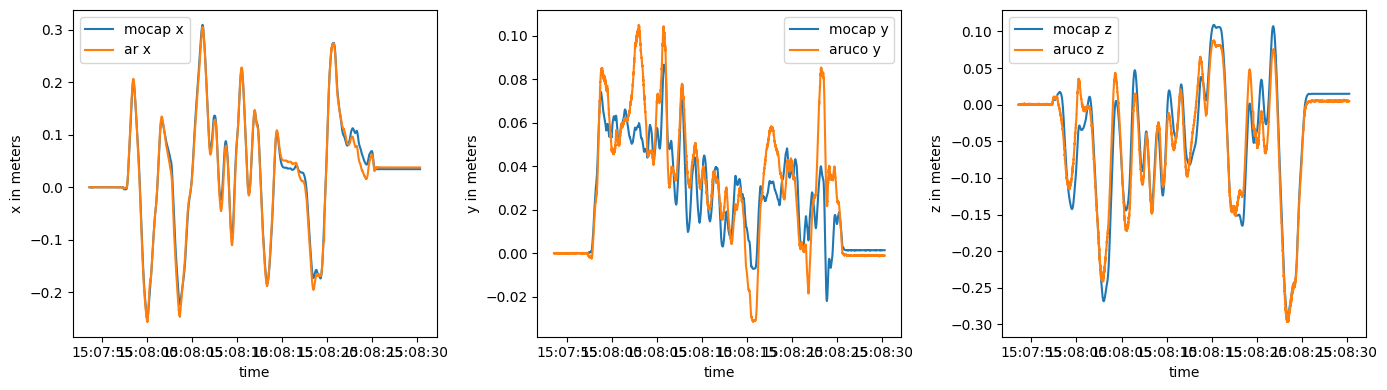

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].plot(ar_df["time"], mocap_ip["x"], label="mocap x")
axes[0].plot(ar_df["time"], t_dict["x"], label="ar x")
axes[0].set_xlabel("time")
axes[0].set_ylabel("x in meters")
axes[0].legend()

axes[1].plot(ar_df["time"], mocap_ip["y"], label="mocap y")
axes[1].plot(ar_df["time"], t_dict["y"], label="aruco y")
axes[1].set_xlabel("time")
axes[1].set_ylabel("y in meters")
axes[1].legend()

axes[2].plot(ar_df["time"], mocap_ip["z"], label="mocap z")
axes[2].plot(ar_df["time"], np.array(t_dict["z"]), label="aruco z")
axes[2].set_xlabel("time")
axes[2].set_ylabel("z in meters")
axes[2].legend()
# axes[2].set_ylim([-0.01, 0.01])

plt.tight_layout()
plt.show()

In [20]:
_cumulative_error = (
    np.array(error_dict["max_x"])
    + np.array(error_dict["max_y"])
    + np.array(error_dict["max_z"])
)
np.argmin(_cumulative_error)

2572

In [23]:
mtx1 = error_dict["mtx"][index]
dist1 = error_dict["dist_coeffs"][index]

In [24]:
error_dict["dist_coeffs"][index]

array([[-0.03554025, -0.31041969, -0.00555178, -0.00835112,  0.23764884]])

In [31]:
import toml

data = toml.load(r"E:\CMC\pyprojects\programs_rpi\rpi_python\calib_test.toml")
data["calibration"]["camera_matrix"] = mtx1.tolist()
data["calibration"]["dist_coeffs"] = dist1.tolist()
data["camera"]["resolution"] = (1200, 480)
with open(
    r"E:\CMC\pyprojects\programs_rpi\rpi_python\calib_mono_faith3D.toml", "w"
) as f:
    toml.dump(data, f)

In [37]:
key = "error"

index = np.argmin(error_dict[key])

# index = 65
camera_matrix = error_dict["mtx"][index]
dist_coeffs = error_dict["dist_coeffs"][index]

rvecs = []
tvecs = []
for _c, _i in zip(corners, ids):
    if (_i is not None and len(_i) > 0) and all(
        item in default_ids for item in np.array(_i)
    ):
        rotation_vectors, translation_vectors = estimate_pose_single_markers(
            corners=_c,
            marker_size=0.05,
            camera_matrix=camera_matrix,
            distortion_coefficients=dist_coeffs,
        )
        rvecs.append(rotation_vectors[0][0])
        tvecs.append(translation_vectors[0][0])

    else:
        rvecs.append(np.array([np.nan, np.nan, np.nan]))
        tvecs.append(np.array([np.nan, np.nan, np.nan]))

tvecs = np.array(tvecs)
rvecs = np.array(rvecs)

t_dict = {"x": [], "y": [], "z": []}
rmat = cv2.Rodrigues(rvecs[1])[0]
ang_dict = {"rx": [], "ry": [], "rz": []}
for i in range(len(tvecs)):
    tvec = rmat.T @ (tvecs[i].reshape(3, 1) - tvecs[1].reshape(3, 1))
    tvec = tvec.T[0]
    t_dict["x"].append(tvec[0])
    t_dict["y"].append(tvec[1])
    t_dict["z"].append(tvec[2])
    _ang = R.from_matrix(rmat.T @ R.from_rotvec(rvecs[i]).as_matrix()).as_euler(
        "XYZ", degrees=True
    )
    ang_dict["rx"].append(_ang[0])
    ang_dict["ry"].append(_ang[1])
    ang_dict["rz"].append(_ang[2])

In [38]:
index

2566

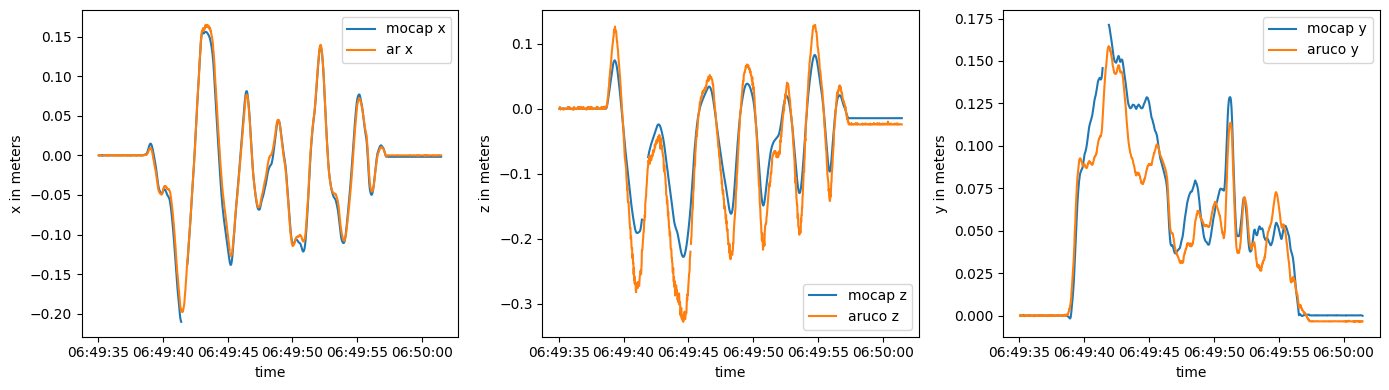

In [39]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

axes[0].plot(ar_df["time"], mocap_ip["x"], label="mocap x")
axes[0].plot(ar_df["time"], t_dict["x"], label="ar x")
axes[0].set_xlabel("time")
axes[0].set_ylabel("x in meters")
axes[0].legend()

axes[1].plot(ar_df["time"], mocap_ip["z"], label="mocap z")
axes[1].plot(ar_df["time"], np.array(t_dict["z"]), label="aruco z")
axes[1].set_xlabel("time")
axes[1].set_ylabel("z in meters")
axes[1].legend()

axes[2].plot(ar_df["time"], mocap_ip["y"], label="mocap y")
axes[2].plot(ar_df["time"], t_dict["y"], label="aruco y")
axes[2].set_xlabel("time")
axes[2].set_ylabel("y in meters")
axes[2].legend()
# axes[2].set_ylim([-0.01, 0.01])

plt.tight_layout()
plt.show()